In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [6]:
# Read Image and printout some stats
image = mpimg.imread('F:/Udacity/SelfDrivingCar/test.jpg')
print('This image is: ', type(image), ' with dimensions:',image.shape)

This image is:  <class 'numpy.ndarray'>  with dimensions: (540, 960, 3)


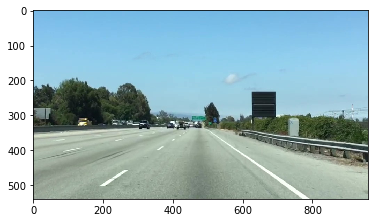

In [7]:
# plot the image
plt.imshow(image)
plt.show()

In [8]:
# Grab x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
region_select = np.copy(image)
line_image = np.copy(image)

In [9]:
# Define our color selection criteria
# Threshold values, minimum values that you will allow in your selection
red_threshold = 200 # selecting 200 since we are looking for a value of 255 (white), this gives it some flexibility
green_threshold = 200
blue_threshold = 200 
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [10]:
# shape of 1 channel of color
image[:,:,0].shape

(540, 960)

In [11]:
# Identify pixles below the threshold
# "|" Bitwise OR operator
# "\" Line continuation in next line
# Mask pixles below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
# Set all location below the threshold black
color_select[color_thresholds] = [0,0,0]

In [12]:
color_thresholds.shape, color_select.shape

((540, 960), (540, 960, 3))

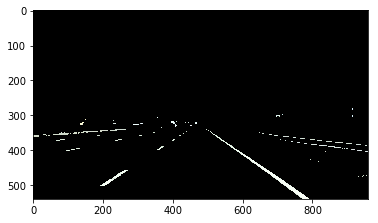

In [13]:
plt.imshow(color_select)
plt.show()

In [14]:
(image[:,:,0] < rgb_threshold[0]).shape

(540, 960)

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

The variables left_bottom, right_bottom, and apex represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but later you'll use a quadrilateral, and in principle, you could use any polygon.

In [15]:
# Define a triangular region of interest
# Cooridnates (x=0,y=0) are in the upper left corner for image processing
left_bottom = [140,540] #[0,539]
right_bottom = [800, 540] #[900, 539]
apex = [450,300] #[475,320]

In [16]:
# Fit lines (y=Ax+B) to identify the 3 sided region of interest
# np.polyfit() returns the coefficient [A, B] of the fit
fit_left = np.polyfit((left_bottom[0],apex[0]),(left_bottom[1],apex[1]), 1)
fit_right = np.polyfit((right_bottom[0],apex[0]),(right_bottom[1],apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]),(left_bottom[1], right_bottom[1]), 1)

In [17]:
# find the region inside the lines
# We create a grid with every point in the work space
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
# yy > y=(mx+c)
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [18]:
XX.shape,YY.shape

((540, 960), (540, 960))

In [19]:
# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255,0,0]

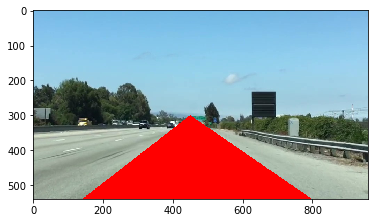

In [20]:
plt.imshow(region_select)
plt.show()

In [21]:
# Find where image is both colored right and in the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

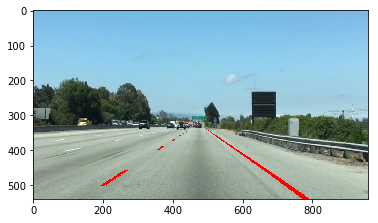

In [22]:
plt.imshow(color_select)
plt.imshow(line_image)
plt.show()

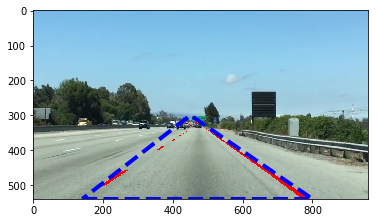

In [23]:
# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
plt.imshow(line_image)
plt.show()

lane lines are not always the same color, and even lines of the same color under different lighting conditions (day, night, etc) may fail to be detected by our simple color selection.

What we need is to take our algorithm to the next level to detect lines of any color using sophisticated computer vision methods.

# Edge Detection Using Computer Vision

### Canny Edge Detector

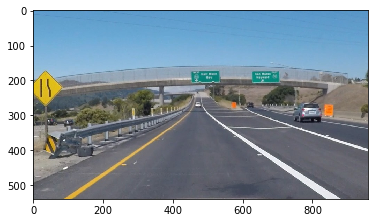

In [26]:
image2 = mpimg.imread('F:/Udacity/SelfDrivingCar/exit-ramp.jpg')
plt.imshow(image2)
plt.show()

In [29]:
# Grab x and y sizes and make copy of the image
print("This image is: ",type(image2), ' with dimensions: ', image2.shape)
ysize = image2.shape[0]
xsize = image2.shape[1]

This image is:  <class 'numpy.ndarray'>  with dimensions:  (540, 960, 3)


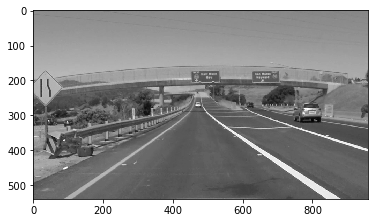

In [32]:
# convert to grayscale
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image2, cmap='gray')
plt.show()

The algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. 

Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. 

The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else. 

converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255.

This range implies that derivatives (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds. So, a reasonable range for your threshold parameters would also be in the tens to hundreds.

As far as a ratio of low_threshold to high_threshold, John Canny himself recommended a low to high ratio of 1:2 or 1:3.

We'll also include Gaussian smoothing, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging 

You can choose the kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area. Eg. 3

In [53]:
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray_image2 = cv2.GaussianBlur(gray_image2, (kernel_size, kernel_size), 0)

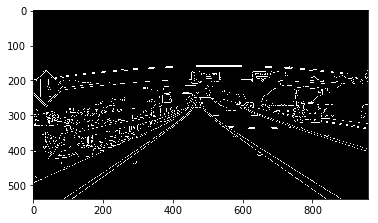

In [54]:
low_threshold = 50
high_threshold =150
# apply canny edge detector function from opencv
edges = cv2.Canny(blur_gray_image2, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()